# Import Libraries

In [ ]:
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import string
import numpy as np
from sklearn import metrics
from bs4 import BeautifulSoup
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, AutoTokenizer, BertModel, BertConfig, AutoModel, AdamW
import warnings
import seaborn as sns
import re
#!pip install emoji
#!pip install contractions

# Ignore warnings
warnings.filterwarnings('ignore')


# Load the dataset

In [ ]:
from google.colab import files
uploaded = files.upload()
SLPath = 'train.tsv', 'test.tsv', 'dev.tsv'

# Load the training data
train_df = pd.read_csv('train.tsv', delimiter="\t", header=None, names=["Comment", "Class", "Delete"])
# Load the test data
test_df = pd.read_csv('test.tsv', delimiter="\t", header=None, names=["Comment", "Class", "Delete"])
# Load the validation data
validation_df = pd.read_csv('dev.tsv', delimiter="\t", header=None, names=["Comment", "Class", "Delete"])

Saving train.tsv to train.tsv
Saving test.tsv to test.tsv
Saving dev.tsv to dev.tsv


GoEmotions is a dataset with 58000 Reddit comments labeled with 28 emotions:

admiration, amusement, anger, annoyance, approval, caring, confusion, curiosity, desire, disappointment, disapproval, disgust, embarrassment, excitement, fear, gratitude, grief, joy, love, nervousness, optimism, pride, realization, relief, remorse, sadness, surprise + neutral

In [ ]:
train_df

Comment Class   Delete
0      My favourite food is anything I didn't have to...    27  eebbqej
1      Now if he does off himself, everyone will thin...    27  ed00q6i
2                         WHY THE FUCK IS BAYLESS ISOING     2  eezlygj
3                            To make her feel threatened    14  ed7ypvh
4                                 Dirty Southern Wankers     3  ed0bdzj
...                                                  ...   ...      ...
43405  Added you mate well I’ve just got the bow and ...    18  edsb738
43406  Always thought that was funny but is it a refe...     6  ee7fdou
43407  What are you talking about? Anything bad that ...     3  efgbhks
43408            More like a baptism, with sexy results!    13  ed1naf8
43409                                    Enjoy the ride!    17  eecwmbq

[43410 rows x 3 columns]

In [ ]:
# dropping the "Delete" column
train_df = train_df.drop("Delete", axis=1)
test_df = test_df.drop("Delete", axis=1)
validation_df = validation_df.drop("Delete", axis=1)

In [ ]:
print(train_df.shape)
print(test_df.shape)
print(validation_df.shape)

(43410, 2)
(5427, 2)
(5426, 2)


In [ ]:
train_df.head()

Comment Class
0  My favourite food is anything I didn't have to...    27
1  Now if he does off himself, everyone will thin...    27
2                     WHY THE FUCK IS BAYLESS ISOING     2
3                        To make her feel threatened    14
4                             Dirty Southern Wankers     3

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43410 entries, 0 to 43409
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Comment  43410 non-null  object
 1   Class    43410 non-null  object
dtypes: object(2)
memory usage: 678.4+ KB


# Multiple Emotion Labels:
In the dataset, some comments are associated with multiple emotion labels, which are separated by commas in the "Class" column. To handle this, we create a "Class list" column by splitting the "Class" column string values into lists. This allows us to treat each comment's multiple labels as a list of labels, making it easier to analyze and manipulate the data.

In [ ]:
# Create a new column "Class list" by splitting the "Class" column strings at each comma
train_df["Class list"] = train_df["Class"].apply(lambda x: x.split(","))
# Create a new column "Class len" that contains the length of each list in the "Class list" column
train_df["Class len"] = train_df["Class list"].apply(lambda x: len(x))

# Repeat the same process for the test data
test_df["Class list"] = test_df["Class"].apply(lambda x: x.split(","))
test_df["Class len"] = test_df["Class list"].apply(lambda x: len(x))

# Repeat the same process for the validation data
validation_df["Class list"] = validation_df["Class"].apply(lambda x: x.split(","))
validation_df["Class len"] = validation_df["Class list"].apply(lambda x: len(x))

In [ ]:
train_df

Comment Class Class list  \
0      My favourite food is anything I didn't have to...    27       [27]   
1      Now if he does off himself, everyone will thin...    27       [27]   
2                         WHY THE FUCK IS BAYLESS ISOING     2        [2]   
3                            To make her feel threatened    14       [14]   
4                                 Dirty Southern Wankers     3        [3]   
...                                                  ...   ...        ...   
43405  Added you mate well I’ve just got the bow and ...    18       [18]   
43406  Always thought that was funny but is it a refe...     6        [6]   
43407  What are you talking about? Anything bad that ...     3        [3]   
43408            More like a baptism, with sexy results!    13       [13]   
43409                                    Enjoy the ride!    17       [17]   

       Class len  
0              1  
1              1  
2              1  
3              1  
4              1  
...          ...  
43405          1  
43406          1  
43407          1  
43408          1  
43409          1  

[43410 rows x 4 columns]

In [ ]:
# Filter rows where "Class len" is greater than 1
train_multiple_emotions = train_df[train_df["Class len"] > 1]
test_multiple_emotions = test_df[test_df["Class len"] > 1]
validation_multiple_emotions = validation_df[validation_df["Class len"] > 1]

In [ ]:
# Display the rows with multiple emotion labels in the training data
print("Training Data - Rows with Multiple Emotion Labels:")
print(train_multiple_emotions)

Training Data - Rows with Multiple Emotion Labels:
                                                 Comment   Class  Class list  \
7      We need more boards and to create a bit more s...    8,20     [8, 20]   
11     Aww... she'll probably come around eventually,...     1,4      [1, 4]   
15     Shit, I guess I accidentally bought a Pay-Per-...    3,12     [3, 12]   
19     Maybe that’s what happened to the great white ...    6,22     [6, 22]   
20     I never thought it was at the same moment, but...  6,9,27  [6, 9, 27]   
...                                                  ...     ...         ...   
43382   goat handshake denied Personally, I just thin...   14,27    [14, 27]   
43383                                     it's horrid :/   14,27    [14, 27]   
43388  Fuck these trendy hipster joints. Give me my s...     2,3      [2, 3]   
43395  Sorry I kind of took it like you were flexing ...    1,24     [1, 24]   
43404  Your paranoia over it seems schizophrenic to m...    7,27     

In [ ]:
# Display the rows with multiple emotion labels in the test data
print("\nTest Data - Rows with Multiple Emotion Labels:")
print(test_multiple_emotions)


Test Data - Rows with Multiple Emotion Labels:
                                                Comment  Class Class list  \
10    [NAME] has towed the line of the Dark Side. He...   3,10    [3, 10]   
11            Lol! But I love your last name though. XD   1,18    [1, 18]   
13    It's great that you're a recovering addict, th...    0,7     [0, 7]   
17    if the pain doesn't go away after 4 hours or s...  25,27   [25, 27]   
24    Watch Vegan Gains’ video on that, he had it wh...   6,27    [6, 27]   
...                                                 ...    ...        ...   
5404  Hahaha so I’m no longer going to worry about i...   1,20    [1, 20]   
5413  This will be me a year from now. Not fair at all.  10,12   [10, 12]   
5414  I know, right?! I was literally in tears Satur...   7,25    [7, 25]   
5415            They are children, they have no souls.     4,5     [4, 5]   
5419  My mom works for Nasa and apparently no. They ...   1,11    [1, 11]   

      Class len  
10       

In [ ]:
# Display the rows with multiple emotion labels in the validation data
print("\nValidation Data - Rows with Multiple Emotion Labels:")
print(validation_multiple_emotions)


Validation Data - Rows with Multiple Emotion Labels:
                                                Comment   Class  Class list  \
1     You know the answer man, you are programmed to...    4,27     [4, 27]   
3     The economy is heavily controlled and subsidiz...    4,27     [4, 27]   
11    I went to a destination wedding being the only...   12,22    [12, 22]   
14    Lol dream on buddy. You’ve had enough attentio...  1,3,25  [1, 3, 25]   
15    As an anesthesia resident this made me blow ai...     2,3      [2, 3]   
...                                                 ...     ...         ...   
5395  Great cover of my favorite song. I loved watch...    0,18     [0, 18]   
5399                                   Damn this got me    3,27     [3, 27]   
5401                                  cool... Sorry bro   24,25    [24, 25]   
5405       Very very nice to see this irl. Nice post 👌🏼     0,4      [0, 4]   
5413  Yup! She was also on a show called Queen Bees ...     4,7      [4, 7]  

# Ekman’s Basic Emotions:
As mentioned above, GoEmotions uses 27 emotions to annotate Reddit comments. We are going to map these emotions to Ekman's 6 basic emotion categories: joy, anger, fear, sadness, disgust, and surprise

In [ ]:
# Load the Ekman mapping JSON file
uploaded = files.upload()
SLpath = 'ekman_mapping.json'
with open('ekman_mapping.json', 'r') as f:
    ekman_mapping = json.load(f)

# Display the loaded JSON data
print(ekman_mapping)

Saving ekman_mapping.json to ekman_mapping.json
{'anger': ['anger', 'annoyance', 'disapproval'], 'disgust': ['disgust'], 'fear': ['fear', 'nervousness'], 'joy': ['joy', 'amusement', 'approval', 'excitement', 'gratitude', 'love', 'optimism', 'relief', 'pride', 'admiration', 'desire', 'caring'], 'sadness': ['sadness', 'disappointment', 'embarrassment', 'grief', 'remorse'], 'surprise': ['surprise', 'realization', 'confusion', 'curiosity']}


In [ ]:
uploaded = files.upload()
SLpath = 'emotions.txt'
emotion_file = open('emotions.txt', "r")
emotion_list = emotion_file.read()
emotion_list = emotion_list.split("\n")
print(emotion_list)
print(len(emotion_list))

Saving emotions.txt to emotions.txt
['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']
28


In [ ]:
train_df

Comment Class Class list  \
0      My favourite food is anything I didn't have to...    27       [27]   
1      Now if he does off himself, everyone will thin...    27       [27]   
2                         WHY THE FUCK IS BAYLESS ISOING     2        [2]   
3                            To make her feel threatened    14       [14]   
4                                 Dirty Southern Wankers     3        [3]   
...                                                  ...   ...        ...   
43405  Added you mate well I’ve just got the bow and ...    18       [18]   
43406  Always thought that was funny but is it a refe...     6        [6]   
43407  What are you talking about? Anything bad that ...     3        [3]   
43408            More like a baptism, with sexy results!    13       [13]   
43409                                    Enjoy the ride!    17       [17]   

       Class len  
0              1  
1              1  
2              1  
3              1  
4              1  
...          ...  
43405          1  
43406          1  
43407          1  
43408          1  
43409          1  

[43410 rows x 4 columns]

In [ ]:
def idx2class(idxlist):
    arr = []
    for i in idxlist:
        arr.append(emotion_list[int(i)])
    return arr

In [ ]:
# Converting the class indexes back to class names
train_df["Emotion"] = train_df["Class list"].apply(idx2class)
test_df["Emotion"] = test_df["Class list"].apply(idx2class)
validation_df["Emotion"] = validation_df["Class list"].apply(idx2class)

In [ ]:
# Display rows with multiple emotions
train_df[train_df["Class len"] > 1]

Comment   Class  Class list  \
7      We need more boards and to create a bit more s...    8,20     [8, 20]   
11     Aww... she'll probably come around eventually,...     1,4      [1, 4]   
15     Shit, I guess I accidentally bought a Pay-Per-...    3,12     [3, 12]   
19     Maybe that’s what happened to the great white ...    6,22     [6, 22]   
20     I never thought it was at the same moment, but...  6,9,27  [6, 9, 27]   
...                                                  ...     ...         ...   
43382   goat handshake denied Personally, I just thin...   14,27    [14, 27]   
43383                                     it's horrid :/   14,27    [14, 27]   
43388  Fuck these trendy hipster joints. Give me my s...     2,3      [2, 3]   
43395  Sorry I kind of took it like you were flexing ...    1,24     [1, 24]   
43404  Your paranoia over it seems schizophrenic to m...    7,27     [7, 27]   

       Class len                               Emotion  
7              2                    [desire, optimism]  
11             2                 [amusement, approval]  
15             2            [annoyance, embarrassment]  
19             2              [confusion, realization]  
20             3  [confusion, disappointment, neutral]  
...          ...                                   ...  
43382          2                       [fear, neutral]  
43383          2                       [fear, neutral]  
43388          2                    [anger, annoyance]  
43395          2                  [amusement, remorse]  
43404          2                  [curiosity, neutral]  

[7102 rows x 5 columns]

In [ ]:
def EmotionMapping(emotion_list):
    map_list = []

    for i in emotion_list:
        if i in ekman_mapping["anger"]:
            map_list.append("anger")
        if i in ekman_mapping["disgust"]:
            map_list.append("disgust")
        if i in ekman_mapping["fear"]:
            map_list.append("fear")
        if i in ekman_mapping["joy"]:
            map_list.append("joy")
        if i in ekman_mapping["sadness"]:
            map_list.append("sadness")
        if i in ekman_mapping["surprise"]:
            map_list.append("surprise")
        if i == "neutral":
            map_list.append("neutral")

    return map_list

In [ ]:
# Convert the classes based on Ekman Taxonomy
train_df["Mapped_emotion"] = train_df['Emotion'].apply(EmotionMapping)
test_df["Mapped_emotion"] = test_df['Emotion'].apply(EmotionMapping)
validation_df["Mapped_emotion"] = validation_df['Emotion'].apply(EmotionMapping)

In [ ]:
# Display rows with multiple emotions
train_df[train_df["Class len"] > 1]

Comment   Class  Class list  \
7      We need more boards and to create a bit more s...    8,20     [8, 20]   
11     Aww... she'll probably come around eventually,...     1,4      [1, 4]   
15     Shit, I guess I accidentally bought a Pay-Per-...    3,12     [3, 12]   
19     Maybe that’s what happened to the great white ...    6,22     [6, 22]   
20     I never thought it was at the same moment, but...  6,9,27  [6, 9, 27]   
...                                                  ...     ...         ...   
43382   goat handshake denied Personally, I just thin...   14,27    [14, 27]   
43383                                     it's horrid :/   14,27    [14, 27]   
43388  Fuck these trendy hipster joints. Give me my s...     2,3      [2, 3]   
43395  Sorry I kind of took it like you were flexing ...    1,24     [1, 24]   
43404  Your paranoia over it seems schizophrenic to m...    7,27     [7, 27]   

       Class len                               Emotion  \
7              2                    [desire, optimism]   
11             2                 [amusement, approval]   
15             2            [annoyance, embarrassment]   
19             2              [confusion, realization]   
20             3  [confusion, disappointment, neutral]   
...          ...                                   ...   
43382          2                       [fear, neutral]   
43383          2                       [fear, neutral]   
43388          2                    [anger, annoyance]   
43395          2                  [amusement, remorse]   
43404          2                  [curiosity, neutral]   

                     Mapped_emotion  
7                        [joy, joy]  
11                       [joy, joy]  
15                 [anger, sadness]  
19             [surprise, surprise]  
20     [surprise, sadness, neutral]  
...                             ...  
43382               [fear, neutral]  
43383               [fear, neutral]  
43388                [anger, anger]  
43395                [joy, sadness]  
43404           [surprise, neutral]  

[7102 rows x 6 columns]

In [ ]:
train_df["Mapped_emotion"] = train_df["Mapped_emotion"].apply(lambda x: ','.join(x))
test_df["Mapped_emotion"] = test_df["Mapped_emotion"].apply(lambda x: ','.join(x))
validation_df["Mapped_emotion"] = validation_df["Mapped_emotion"].apply(lambda x: ','.join(x))

In [ ]:
# Display rows with multiple emotions
train_df[train_df["Class len"] > 1]

Comment   Class  Class list  \
7      We need more boards and to create a bit more s...    8,20     [8, 20]   
11     Aww... she'll probably come around eventually,...     1,4      [1, 4]   
15     Shit, I guess I accidentally bought a Pay-Per-...    3,12     [3, 12]   
19     Maybe that’s what happened to the great white ...    6,22     [6, 22]   
20     I never thought it was at the same moment, but...  6,9,27  [6, 9, 27]   
...                                                  ...     ...         ...   
43382   goat handshake denied Personally, I just thin...   14,27    [14, 27]   
43383                                     it's horrid :/   14,27    [14, 27]   
43388  Fuck these trendy hipster joints. Give me my s...     2,3      [2, 3]   
43395  Sorry I kind of took it like you were flexing ...    1,24     [1, 24]   
43404  Your paranoia over it seems schizophrenic to m...    7,27     [7, 27]   

       Class len                               Emotion  \
7              2                    [desire, optimism]   
11             2                 [amusement, approval]   
15             2            [annoyance, embarrassment]   
19             2              [confusion, realization]   
20             3  [confusion, disappointment, neutral]   
...          ...                                   ...   
43382          2                       [fear, neutral]   
43383          2                       [fear, neutral]   
43388          2                    [anger, annoyance]   
43395          2                  [amusement, remorse]   
43404          2                  [curiosity, neutral]   

                 Mapped_emotion  
7                       joy,joy  
11                      joy,joy  
15                anger,sadness  
19            surprise,surprise  
20     surprise,sadness,neutral  
...                         ...  
43382              fear,neutral  
43383              fear,neutral  
43388               anger,anger  
43395               joy,sadness  
43404          surprise,neutral  

[7102 rows x 6 columns]

In [ ]:
train_df_1= train_df["Mapped_emotion"].str.split(",", expand=True)
test_df_1= test_df["Mapped_emotion"].str.split(",", expand=True)
validation_df_1= validation_df["Mapped_emotion"].str.split(",", expand=True)

In [ ]:
train_df_1[train_df_1.notna().all(axis=1)]

0        1     2     3        4
7873  sadness  sadness  fear  fear  sadness

In [ ]:
train_df_1.drop(train_df_1.columns[1:5], axis=1, inplace=True)
test_df_1.drop(test_df_1.columns[1:5], axis=1, inplace=True)
validation_df_1.drop(validation_df_1.columns[1:5], axis=1, inplace=True)

In [ ]:
train_df_1

0
0       neutral
1       neutral
2         anger
3          fear
4         anger
...         ...
43405       joy
43406  surprise
43407     anger
43408       joy
43409       joy

[43410 rows x 1 columns]

In [ ]:
train_df = pd.concat([train_df, train_df_1], axis=1)
test_df = pd.concat([test_df, test_df_1], axis=1)
validation_df = pd.concat([validation_df, validation_df_1], axis=1)

In [ ]:
# Display rows with multiple emotions
train_df[train_df["Class len"] > 1]

Comment   Class  Class list  \
7      We need more boards and to create a bit more s...    8,20     [8, 20]   
11     Aww... she'll probably come around eventually,...     1,4      [1, 4]   
15     Shit, I guess I accidentally bought a Pay-Per-...    3,12     [3, 12]   
19     Maybe that’s what happened to the great white ...    6,22     [6, 22]   
20     I never thought it was at the same moment, but...  6,9,27  [6, 9, 27]   
...                                                  ...     ...         ...   
43382   goat handshake denied Personally, I just thin...   14,27    [14, 27]   
43383                                     it's horrid :/   14,27    [14, 27]   
43388  Fuck these trendy hipster joints. Give me my s...     2,3      [2, 3]   
43395  Sorry I kind of took it like you were flexing ...    1,24     [1, 24]   
43404  Your paranoia over it seems schizophrenic to m...    7,27     [7, 27]   

       Class len                               Emotion  \
7              2                    [desire, optimism]   
11             2                 [amusement, approval]   
15             2            [annoyance, embarrassment]   
19             2              [confusion, realization]   
20             3  [confusion, disappointment, neutral]   
...          ...                                   ...   
43382          2                       [fear, neutral]   
43383          2                       [fear, neutral]   
43388          2                    [anger, annoyance]   
43395          2                  [amusement, remorse]   
43404          2                  [curiosity, neutral]   

                 Mapped_emotion         0  
7                       joy,joy       joy  
11                      joy,joy       joy  
15                anger,sadness     anger  
19            surprise,surprise  surprise  
20     surprise,sadness,neutral  surprise  
...                         ...       ...  
43382              fear,neutral      fear  
43383              fear,neutral      fear  
43388               anger,anger     anger  
43395               joy,sadness       joy  
43404          surprise,neutral  surprise  

[7102 rows x 7 columns]

In [ ]:
train_df.rename(columns={0: "Single_emotion"}, inplace=True)
test_df.rename(columns={0: "Single_emotion"}, inplace=True)
validation_df.rename(columns={0: "Single_emotion"}, inplace=True)

In [ ]:
train_df[train_df["Class len"] > 1]

Comment   Class  Class list  \
7      We need more boards and to create a bit more s...    8,20     [8, 20]   
11     Aww... she'll probably come around eventually,...     1,4      [1, 4]   
15     Shit, I guess I accidentally bought a Pay-Per-...    3,12     [3, 12]   
19     Maybe that’s what happened to the great white ...    6,22     [6, 22]   
20     I never thought it was at the same moment, but...  6,9,27  [6, 9, 27]   
...                                                  ...     ...         ...   
43382   goat handshake denied Personally, I just thin...   14,27    [14, 27]   
43383                                     it's horrid :/   14,27    [14, 27]   
43388  Fuck these trendy hipster joints. Give me my s...     2,3      [2, 3]   
43395  Sorry I kind of took it like you were flexing ...    1,24     [1, 24]   
43404  Your paranoia over it seems schizophrenic to m...    7,27     [7, 27]   

       Class len                               Emotion  \
7              2                    [desire, optimism]   
11             2                 [amusement, approval]   
15             2            [annoyance, embarrassment]   
19             2              [confusion, realization]   
20             3  [confusion, disappointment, neutral]   
...          ...                                   ...   
43382          2                       [fear, neutral]   
43383          2                       [fear, neutral]   
43388          2                    [anger, annoyance]   
43395          2                  [amusement, remorse]   
43404          2                  [curiosity, neutral]   

                 Mapped_emotion Single_emotion  
7                       joy,joy            joy  
11                      joy,joy            joy  
15                anger,sadness          anger  
19            surprise,surprise       surprise  
20     surprise,sadness,neutral       surprise  
...                         ...            ...  
43382              fear,neutral           fear  
43383              fear,neutral           fear  
43388               anger,anger          anger  
43395               joy,sadness            joy  
43404          surprise,neutral       surprise  

[7102 rows x 7 columns]

In [ ]:
#Checking if the data is balanced or not
train_df.Single_emotion.value_counts()

Single_emotion
joy         16948
neutral     12823
anger        5336
surprise     4489
sadness      2619
fear          615
disgust       580
Name: count, dtype: int64

In [ ]:
train_df.head()

Comment Class Class list  \
0  My favourite food is anything I didn't have to...    27       [27]   
1  Now if he does off himself, everyone will thin...    27       [27]   
2                     WHY THE FUCK IS BAYLESS ISOING     2        [2]   
3                        To make her feel threatened    14       [14]   
4                             Dirty Southern Wankers     3        [3]   

   Class len      Emotion Mapped_emotion Single_emotion  
0          1    [neutral]        neutral        neutral  
1          1    [neutral]        neutral        neutral  
2          1      [anger]          anger          anger  
3          1       [fear]           fear           fear  
4          1  [annoyance]          anger          anger

In [ ]:
# List of columns to drop
columns_to_drop = ['Class list', 'Emotion']

# Drop the specified columns
train_df = train_df.drop(columns=columns_to_drop)
test_df = test_df.drop(columns=columns_to_drop)
validation_df = validation_df.drop(columns=columns_to_drop)

In [ ]:
train_df

Comment Class  Class len  \
0      My favourite food is anything I didn't have to...    27          1   
1      Now if he does off himself, everyone will thin...    27          1   
2                         WHY THE FUCK IS BAYLESS ISOING     2          1   
3                            To make her feel threatened    14          1   
4                                 Dirty Southern Wankers     3          1   
...                                                  ...   ...        ...   
43405  Added you mate well I’ve just got the bow and ...    18          1   
43406  Always thought that was funny but is it a refe...     6          1   
43407  What are you talking about? Anything bad that ...     3          1   
43408            More like a baptism, with sexy results!    13          1   
43409                                    Enjoy the ride!    17          1   

      Mapped_emotion Single_emotion  
0            neutral        neutral  
1            neutral        neutral  
2              anger          anger  
3               fear           fear  
4              anger          anger  
...              ...            ...  
43405            joy            joy  
43406       surprise       surprise  
43407          anger          anger  
43408            joy            joy  
43409            joy            joy  

[43410 rows x 5 columns]

In [ ]:
# Check duplicated values
print("Train data:", train_df.duplicated().sum())
print("Test data:", test_df.duplicated().sum())
print("Validation data:", validation_df.duplicated().sum())

Train data: 113
Test data: 5
Validation data: 2


In [ ]:
#Removing Duplicated values
index = train_df[train_df.duplicated() == True].index
train_df.drop(index, axis=0, inplace=True)
train_df.reset_index(inplace=True, drop=True)

index = test_df[test_df.duplicated() == True].index
test_df.drop(index, axis=0, inplace=True)
test_df.reset_index(inplace=True, drop=True)

index = validation_df[validation_df.duplicated() == True].index
validation_df.drop(index, axis=0, inplace=True)
validation_df.reset_index(inplace=True, drop=True)

In [ ]:
# Check duplicated values
print("Train data:", train_df.duplicated().sum())
print("Test data:", test_df.duplicated().sum())
print("Validation data:", validation_df.duplicated().sum())

Train data: 0
Test data: 0
Validation data: 0


In [ ]:
#print rows which are duplicated in the text but the same emotion
train_df[train_df["Comment"].duplicated() == True]

Comment  Class  Class len  \
4617                               I miss [NAME]     25          1   
6274                             Happy cake day!     13          1   
6549                             Happy cake day!  13,17          2   
6613                                     My man!     21          1   
7928                           What do you mean?      7          1   
...                                          ...    ...        ...   
41162                                   So edgy.     14          1   
41578                        This hurts my brain     25          1   
41756  A surprise to be sure, but a welcome one.     13          1   
41961                        Love your username!      0          1   
42592                       I was just joking...     17          1   

      Mapped_emotion Single_emotion  
4617         sadness        sadness  
6274             joy            joy  
6549         joy,joy            joy  
6613             joy            joy  
7928        surprise       surprise  
...              ...            ...  
41162           fear           fear  
41578        sadness        sadness  
41756            joy            joy  
41961            joy            joy  
42592            joy            joy  

[70 rows x 5 columns]

In [ ]:
# Removing the duplicate text
index = train_df[train_df["Comment"].duplicated() == True].index
train_df.drop(index, axis=0, inplace = True)
train_df.reset_index(inplace=True, drop=True)

In [ ]:
#print rows which are duplicated in the text but the same emotion
test_df[test_df["Comment"].duplicated() == True]

Comment Class  Class len Mapped_emotion Single_emotion
4814  Happy cake day!    17          1            joy            joy

In [ ]:
#print rows which are duplicated in the text but the same emotion
validation_df[validation_df["Comment"].duplicated() == True]

Comment Class  Class len Mapped_emotion Single_emotion
5236  I like it!     0          1            joy            joy

# Data Preprocessing

In [ ]:
!pip install emoji
!pip install contractions

import emoji
import contractions

def replace_multiple_occurrences(text):
    # Define a pattern to match consecutive letters repeated more than twice; example "coooool" turns into --> cool
    pattern = r"(\w)(\1{2,})"  # Matches a letter (\w) followed by the same letter repeated 2 or more times

    # Use a lambda function to handle replacements
    processed_text = re.sub(pattern, lambda m: m.group(1) * 2, text)

    return processed_text
def preprocess_comments(x):

    # Adding a space between words and punctuation
    x = re.sub(r'([a-zA-Z])([,;.!?])', r'\1 \2', x)
    x = re.sub(r'([,;.!?])([a-zA-Z])', r'\1 \2', x)

    # Demojize emojis
    x = emoji.demojize(x)

    # Expand contractions
    x = contractions.fix(x)

    # Convert to lowercase
    x = x.lower()

    # Correct acronyms/typos/abbreviations
    x = re.sub(r"lmao", "laughing my ass off", x)
    x = re.sub(r"amirite", "am i right", x)
    x = re.sub(r"\b(tho)\b", "though", x)
    x = re.sub(r"\b(ikr)\b", "i know right", x)
    x = re.sub(r"\b(ya|u)\b", "you", x)
    x = re.sub(r"\b(eu)\b", "europe", x)
    x = re.sub(r"\b(da)\b", "the", x)
    x = re.sub(r"\b(dat)\b", "that", x)
    x = re.sub(r"\b(dats)\b", "that is", x)
    x = re.sub(r"\b(cuz)\b", "because", x)
    x = re.sub(r"\b(fkn)\b", "fucking", x)
    x = re.sub(r"\b(tbh)\b", "to be honest", x)
    x = re.sub(r"\b(tbf)\b", "to be fair", x)
    x = re.sub(r"faux pas", "mistake", x)
    x = re.sub(r"\b(btw)\b", "by the way", x)
    x = re.sub(r"\b(bs)\b", "bullshit", x)
    x = re.sub(r"\b(kinda)\b", "kind of", x)
    x = re.sub(r"\b(bruh)\b", "bro", x)
    x = re.sub(r"\b(w/e)\b", "whatever", x)
    x = re.sub(r"\b(w/)\b", "with", x)
    x = re.sub(r"\b(w/o)\b", "without", x)
    x = re.sub(r"\b(doj)\b", "department of justice", x)

    # Handling emojis
    x = re.sub(r"<3", " love ", x)
    x = re.sub(r"xd", " smiling_face_with_open_mouth_and_tightly_closed_eyes ", x)
    x = re.sub(r":\)", " smiling_face ", x)
    x = re.sub(r"^_^", " smiling_face ", x)
    x = re.sub(r"\*_\*", " star_struck ", x)
    x = re.sub(r":\(", " frowning_face ", x)
    x = re.sub(r":\^\(", " frowning_face ", x)
    x = re.sub(r";\(", " frowning_face ", x)
    x = re.sub(r":\/",  " confused_face", x)
    x = re.sub(r";\)",  " wink", x)
    x = re.sub(r">__<",  " unamused ", x)
    x = re.sub(r"\b([xo]+x*)\b", " xoxo ", x)
    x = re.sub(r"\b(n+a+h+)\b", "no", x)

    # Handling special cases of text
    x = re.sub(r"h a m b e r d e r s", "hamberders", x)
    x = re.sub(r"b e n", "ben", x)
    x = re.sub(r"y i k e s", "yikes", x)
    x = re.sub(r"s p o i l e r", "spoiler", x)
    x = re.sub(r"thankyou", "thank you", x)
    x = re.sub(r"a^r^o^o^o^o^o^o^o^n^d", "around", x)

    # Replace words with multiple occurrences of a letter
    x = replace_multiple_occurrences(x)

    # Remove special characters, numbers, and replace by space
    x = re.sub(r"\b([.]{3,})", " dots ", x)
    x = re.sub(r"[^A-Za-z!?_]+", " ", x)
    x = re.sub(r"\b([s])\b *", "", x)
    x = re.sub(r" +", " ", x)
    x = x.strip()

    return x


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 7.9 MB/s eta 0:00:00


In [ ]:
train_df['Comment'] = train_df['Comment'].apply(preprocess_comments)
test_df['Comment'] = test_df['Comment'].apply(preprocess_comments)
validation_df['Comment'] = validation_df['Comment'].apply(preprocess_comments)

In [ ]:
train_df[300:320]

Comment  Class  Class len  \
300  r hockey has no love for us ! just stay here w...     27          1   
301  they do not seem to care much al qaida or ahra...     10          1   
302  the number recruit from the class at usc has a...      1          1   
303                                         no me good     27          1   
304  i have his signature on my jersey lined up at ...     17          1   
305  every day it gets harder to tell the differenc...    3,9          2   
306  i am just like this ! glad to know i am not im...     21          1   
307  i do not understand why everything in this scr...     27          1   
308     the logic is so the government can oppress you     27          1   
309  oh yeah ! he was great for us era in g with k ...      0          1   
310   i hope for the camera man sake that gun is empty     20          1   
311                      name meet name love that show  18,27          2   
312                  please never do not not reproduce      3          1   
313  source each of these and trend lines from prev...     10          1   
314  holy shit this golden comment flew under the r...      1          1   
315  saying babcuck should be fired woke give me up...     27          1   
316  name rescued me as well i also had a couple we...     27          1   
317  also the detroit police underwater recovery te...     27          1   
318  it is like you did not even read the comment y...     22          1   
319      they hated him because he told them the truth     25          1   

    Mapped_emotion Single_emotion  
300        neutral        neutral  
301          anger          anger  
302            joy            joy  
303        neutral        neutral  
304            joy            joy  
305  anger,sadness          anger  
306            joy            joy  
307        neutral        neutral  
308        neutral        neutral  
309            joy            joy  
310            joy            joy  
311    joy,neutral            joy  
312          anger          anger  
313          anger          anger  
314            joy            joy  
315        neutral        neutral  
316        neutral        neutral  
317        neutral        neutral  
318       surprise       surprise  
319        sadness        sadness

# Distribution of Emotions

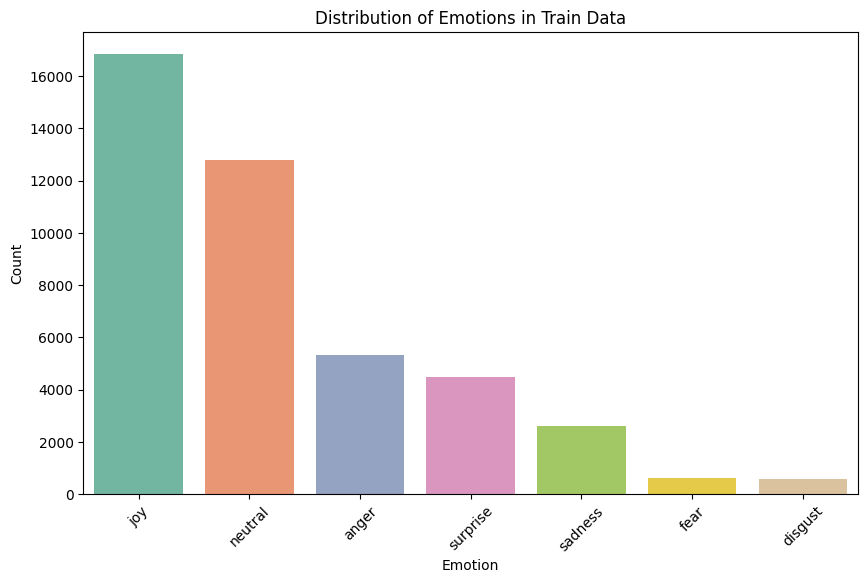

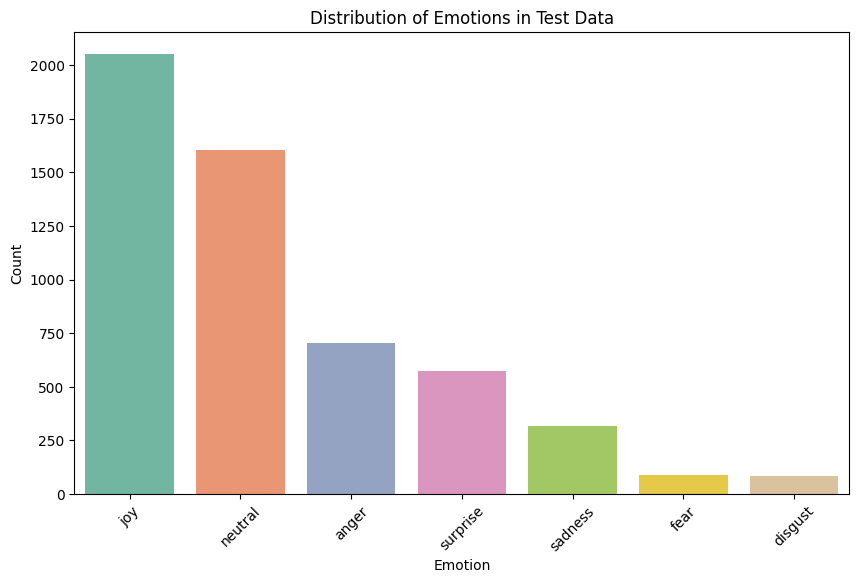

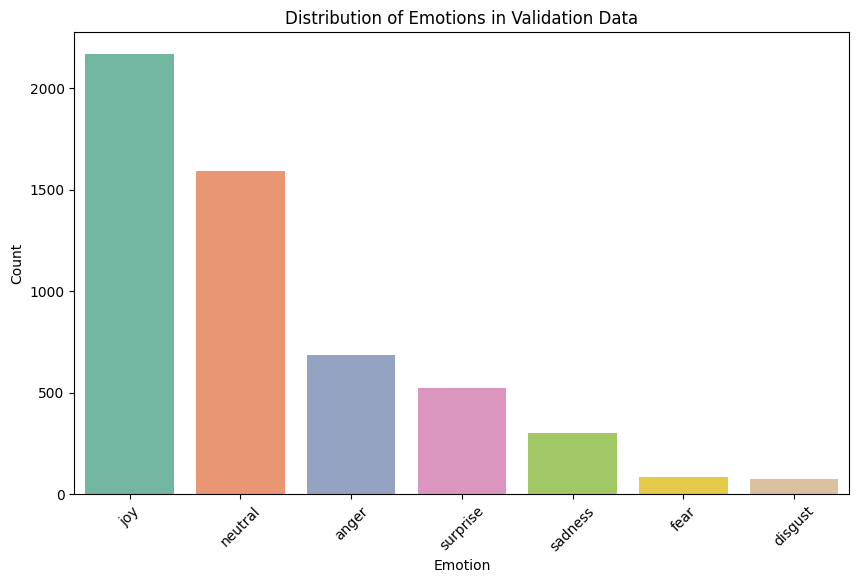

In [ ]:
# Define a color palette with different colors for each emotion
colors = sns.color_palette("Set2", n_colors=7)  # Adjust n_colors as per your need

# Plotting for train_df
plt.figure(figsize=(10, 6))
sns.countplot(x='Single_emotion', data=train_df, order=train_df['Single_emotion'].value_counts().index, palette=colors)
plt.title('Distribution of Emotions in Train Data')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Plotting for test_df
plt.figure(figsize=(10, 6))
sns.countplot(x='Single_emotion', data=test_df, order=test_df['Single_emotion'].value_counts().index, palette=colors)
plt.title('Distribution of Emotions in Test Data')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Plotting for validation_df
plt.figure(figsize=(10, 6))
sns.countplot(x='Single_emotion', data=validation_df, order=validation_df['Single_emotion'].value_counts().index, palette=colors)
plt.title('Distribution of Emotions in Validation Data')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [ ]:
import nltk
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

nltk.download('wordnet')
nltk.download('punkt')

def tokenizing(text):
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens]
    return ' '.join(tokens)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
train_df['Comment'] = train_df['Comment'].apply(tokenizing)

In [ ]:
test_df['Comment'] = test_df['Comment'].apply(tokenizing)
validation_df['Comment'] = validation_df['Comment'].apply(tokenizing)

In [ ]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_df['Comment'])

In [ ]:
Y_train = train_df['Single_emotion']

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Initialize the Naive Bayes classifier
nb_classifier = MultinomialNB()

# Train the classifier
nb_classifier.fit(X_train, Y_train)

MultinomialNB()

In [ ]:
X_test = vectorizer.transform(test_df['Comment'])
Y_test = test_df['Single_emotion']
y_pred_nb = nb_classifier.predict(X_test)

In [ ]:
print("Naive Bayes Classifier Report:")
print(classification_report(Y_test, y_pred_nb))

Naive Bayes Classifier Report:
              precision    recall  f1-score   support

       anger       0.86      0.02      0.03       703
     disgust       0.00      0.00      0.00        84
        fear       0.00      0.00      0.00        90
         joy       0.46      0.93      0.61      2050
     neutral       0.50      0.37      0.43      1605
     sadness       0.00      0.00      0.00       317
    surprise       0.67      0.00      0.01       573

    accuracy                           0.47      5422
   macro avg       0.35      0.19      0.15      5422
weighted avg       0.50      0.47      0.36      5422



In [ ]:
from sklearn.svm import LinearSVC

# Initialize the SVM classifier
svm_classifier = LinearSVC(loss='squared_hinge')

# Train the classifier
svm_classifier.fit(X_train, Y_train)

# Make predictions on the test set
y_pred_svm = svm_classifier.predict(X_test)

# Evaluate the classifier
print("SVM Classifier Report:")
print(classification_report(Y_test, y_pred_svm))

SVM Classifier Report:
              precision    recall  f1-score   support

       anger       0.50      0.37      0.43       703
     disgust       0.57      0.31      0.40        84
        fear       0.65      0.52      0.58        90
         joy       0.72      0.78      0.75      2050
     neutral       0.52      0.64      0.57      1605
     sadness       0.57      0.38      0.46       317
    surprise       0.43      0.28      0.34       573

    accuracy                           0.60      5422
   macro avg       0.57      0.47      0.50      5422
weighted avg       0.59      0.60      0.59      5422



In [ ]:
from sklearn import tree
tree_classifier = tree.DecisionTreeClassifier()
tree_classifier.fit(X_train, Y_train)
y_pred_tree = tree_classifier.predict(X_test)
print("Decision Tree Classifier Report:")
print(classification_report(Y_test, y_pred_tree))

Decision Tree Classifier Report:
              precision    recall  f1-score   support

       anger       0.31      0.28      0.29       703
     disgust       0.35      0.25      0.29        84
        fear       0.40      0.23      0.29        90
         joy       0.65      0.69      0.67      2050
     neutral       0.45      0.49      0.47      1605
     sadness       0.35      0.26      0.30       317
    surprise       0.30      0.25      0.27       573

    accuracy                           0.49      5422
   macro avg       0.40      0.35      0.37      5422
weighted avg       0.48      0.49      0.49      5422



In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier()

# Train the classifier
rf_classifier.fit(X_train, Y_train)

y_pred_rf = rf_classifier.predict(X_test)

# Evaluate the classifier
print("Random Forest Classifier Report:")
print(classification_report(Y_test, y_pred_rf))


Random Forest Classifier Report:
              precision    recall  f1-score   support

       anger       0.57      0.18      0.27       703
     disgust       0.67      0.21      0.32        84
        fear       0.67      0.11      0.19        90
         joy       0.64      0.79      0.71      2050
     neutral       0.48      0.73      0.58      1605
     sadness       0.75      0.22      0.34       317
    surprise       0.61      0.13      0.22       573

    accuracy                           0.57      5422
   macro avg       0.63      0.34      0.38      5422
weighted avg       0.59      0.57      0.53      5422



In [ ]:
import xgboost
from sklearn.preprocessing import LabelEncoder

# Initialize the XGBoost classifier
xgb_classifier = xgboost.XGBClassifier()

# Initialize LabelEncoder
le = LabelEncoder()

# Fit the encoder on training labels and transform both training and testing labels
Y_train_encoded = le.fit_transform(Y_train)
Y_test_encoded = le.transform(Y_test)

# Train the classifier using encoded labels
xgb_classifier.fit(X_train, Y_train_encoded)

# Make predictions on the test set
y_pred_xgb = xgb_classifier.predict(X_test)

# Evaluate the classifier using encoded labels
print("XGBoost Classifier Report:")
print(classification_report(Y_test_encoded, y_pred_xgb))


XGBoost Classifier Report:
              precision    recall  f1-score   support

           0       0.56      0.29      0.39       703
           1       0.55      0.32      0.41        84
           2       0.66      0.44      0.53        90
           3       0.79      0.73      0.76      2050
           4       0.50      0.81      0.62      1605
           5       0.66      0.38      0.48       317
           6       0.54      0.26      0.35       573

    accuracy                           0.61      5422
   macro avg       0.61      0.46      0.50      5422
weighted avg       0.63      0.61      0.60      5422



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

LR_classifier = LogisticRegression()
LR_classifier.fit(X_train, Y_train)
y_pred_LR = LR_classifier.predict(X_test)

print("Logistic Regression Report:")
print(classification_report(Y_test, y_pred_LR))

Logistic Regression Report:
              precision    recall  f1-score   support

       anger       0.54      0.34      0.42       703
     disgust       0.58      0.25      0.35        84
        fear       0.77      0.30      0.43        90
         joy       0.73      0.79      0.76      2050
     neutral       0.51      0.73      0.60      1605
     sadness       0.68      0.33      0.45       317
    surprise       0.52      0.26      0.35       573

    accuracy                           0.61      5422
   macro avg       0.62      0.43      0.48      5422
weighted avg       0.62      0.61      0.60      5422



In [ ]:
#import tensorflow
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Embedding, LSTM, Dense
#from sklearn.preprocessing import LabelEncoder
#import scipy.sparse as sp

# Convert string labels to numerical using LabelEncoder
#label_encoder = LabelEncoder()
#Y_train_encoded = label_encoder.fit_transform(Y_train)

# Sort indices of X_train if it's a sparse matrix
#if sp.issparse(X_train):
 #   X_train = sp.csr_matrix(X_train.sorted_indices())

# Define the model
#model = Sequential()
#model.add(Embedding(input_dim=len(vectorizer.vocabulary_), output_dim=100, input_length=X_train.shape[1]))
#model.add(LSTM(units=128, return_sequences=True))
#model.add(LSTM(units=128))
#model.add(Dense(units=7, activation='softmax')) # Assuming 7 emotion classes

# Compile the model
#model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model using encoded labels
#model.fit(X_train, Y_train_encoded, epochs=5, batch_size=32)
